# **C-calculate_onset_date.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 26th, 2023

Last modified: July 26th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# <font color='red'>1. download and import packages</font>

In [1]:
!pip install cdsapi --quiet
!pip install imageio[ffmpeg] --quiet
!pip install imageio[pyav] --quiet

import imageio
import cdsapi
import h5py
import urllib.request
from itertools import product
import s3fs, boto3, botocore, pooch
from pythia_datasets import DATASETS
import os, sys, glob, platform, tempfile
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader

# <font color='red'>2. read data</font>

**<font face='Arial' size=4>Yang: option 1 is the file `precip.mon.mean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [15]:
# # data source 1
# ds = xr.open_dataset('shared/Data/Projects/ENSO/precip.mon.mean.nc')
# ds

**<font face='Arial' size=4>Yang: option 2 is the file `NCEP-NCAR version 1` ReAnalysis Dataset under the folder `shared-public/Megaraptor_Pop_Fortepiano/NCEP-NCAR-v1` with time resolution of 1-day and 1-month.</font>**

In [16]:
# # data source 2: ncep-ncar v1
# temporal_res = 'daily'
# start_year, end_year = 1995, 2000
# sfc_var_list  = ['lftx.sfc', 'lftx4.sfc', 'pres.sfc', 'pr_wtr.eatm', 'slp']

# for idx, var in enumerate(sfc_var_list):
#     ds_list = []
#     for year in range(start_year, end_year + 1):
#         file_path = os.path.join('NCEP-NCAR-v1', 'daily', 'surface', f"{var}.{year}.nc")
#         ds_temp = xr.open_dataset(file_path)
#         ds_list.append(ds_temp.sel(time=ds_temp.time.dt.hour == 0))
#         del ds_temp
#     ds_temp = xr.concat(ds_list, dim='time')
#     ds_sfc_daily = ds_temp if idx == 0 else xr.merge([ds_sfc_daily, ds_temp])
#     del ds_temp

In [18]:
# # data source 3: ERA5
# ds = xr.open_dataset(os.path.join('ERA5', 'hourly', 'single_level', '1996-2005_SH.nc'))
# ds

In [9]:
pd.date_range('2018-01-01', periods=1)

DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', freq='D')

In [17]:
np.linspace(-50, 50, data.shape[1])

array([-50.])

In [20]:
# # data source 4: TRMM
mission = '3B42'
idx = 0
for year in range(2001, 2002 + 1):
    version = '7' if ((year < 2000)|(year > 2010)) else '7A'
    for month in range(1, 12 + 1):
        for day in range(1, 31 + 1):
            file_path = f'TRMM/{mission}/{year}/{month:02}/{day:02}/{mission}.{year}{month:02}{day:02}.00.{version}.HDF5'
            if os.path.exists(file_path):
                with h5py.File(file_path, 'r') as hf:
                    print(f"successfully open {file_path}")
                    data = hf['/Grid/precipitation'][:].transpose()
                data = np.where(data <= 0.0, 0.0, data).reshape(1, data.shape[0], data.shape[1])
                da_temp = xr.DataArray(data, coords=[pd.date_range(f'{year}-{month:02}-{day:02}', periods=1), np.linspace(50, -50, data.shape[1]), np.linspace(0, 180, data.shape[2])], dims=['time', 'lat', 'lon'])
                da = xr.concat([da, da_temp], dim='time') if idx != 0 else da_temp
                idx += 1
ds = xr.Dataset({'prcp': da})
ds

successfully open TRMM/3B42/2001/01/01/3B42.20010101.00.7A.HDF5
successfully open TRMM/3B42/2001/01/02/3B42.20010102.00.7A.HDF5
successfully open TRMM/3B42/2001/01/03/3B42.20010103.00.7A.HDF5
successfully open TRMM/3B42/2001/01/04/3B42.20010104.00.7A.HDF5
successfully open TRMM/3B42/2001/01/05/3B42.20010105.00.7A.HDF5
successfully open TRMM/3B42/2001/01/06/3B42.20010106.00.7A.HDF5
successfully open TRMM/3B42/2001/01/07/3B42.20010107.00.7A.HDF5
successfully open TRMM/3B42/2001/01/08/3B42.20010108.00.7A.HDF5
successfully open TRMM/3B42/2001/01/09/3B42.20010109.00.7A.HDF5
successfully open TRMM/3B42/2001/01/10/3B42.20010110.00.7A.HDF5
successfully open TRMM/3B42/2001/01/11/3B42.20010111.00.7A.HDF5
successfully open TRMM/3B42/2001/01/12/3B42.20010112.00.7A.HDF5
successfully open TRMM/3B42/2001/01/13/3B42.20010113.00.7A.HDF5
successfully open TRMM/3B42/2001/01/14/3B42.20010114.00.7A.HDF5
successfully open TRMM/3B42/2001/01/15/3B42.20010115.00.7A.HDF5
successfully open TRMM/3B42/2001/01/16/3

<xarray.Dataset>
Dimensions:  (time: 730, lat: 400, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2002-12-31
  * lat      (lat) float64 50.0 49.75 49.5 49.25 ... -49.25 -49.5 -49.75 -50.0
  * lon      (lon) float64 0.0 0.1251 0.2502 0.3753 ... 179.6 179.7 179.9 180.0
Data variables:
    prcp     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [21]:
ds.prcp.attrs['long_name'] = 'total precipitation'

In [52]:
fontdict = {'family': 'Monospace', 'size': 16, 'style': 'normal', 'weight': 'normal', 'alpha': 1, 'color': 'k'}
vmin, vmax = 0, 50
levels = np.linspace(vmin, vmax, 11)
for day in range(1, 32):
    val = ds.prcp.sel(time=f'2002-12-{day:02}', lon=slice(90, 130), lat=slice(10, -15))
    
    proj = ccrs.Mercator(central_longitude=90.0)
    fig, ax = plt.subplots(subplot_kw={'projection': proj})
    im = ax.pcolormesh(val.lon, val.lat, val, transform=ccrs.PlateCarree(), 
                       vmin=vmin, vmax=vmax, cmap='jet')
    ax.coastlines()
    ax.set_title(ds.prcp.attrs['long_name'], fontdict=fontdict)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.6, linewidth=0.8, linestyle='dashed')
    gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
    gl.right_labels, gl.top_labels = False, False
    gl.xlabel_style, gl.ylabel_style = fontdict, fontdict
    cbar = fig.colorbar(im, orientation='horizontal', 
                        ticks=levels, extend='max')
    cbar.set_label('units: m', fontdict=fontdict)
    if not os.path.exists('fig'):
        os.makedirs('fig')
    plt.savefig(os.path.join('fig', f'2002-12-{day:02}.png'), dpi=200)
    plt.close()

In [53]:
file_nlst = [os.path.join('fig', f'2002-12-{day:02}.png') for day in range(1, 32)]
frame = [imageio.imread(file_name) for file_name in file_nlst]

imageio.mimsave('2002-12.mp4', frame, fps=10, macro_block_size=None, codec="libx264", quality=10)

/tmp/ipykernel_6881/242794763.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = [imageio.imread(file_name) for file_name in file_nlst]


# 2. calculate the onset date of monsoon

**<font size=4 face='Arial' color='002DE5'>The onset date is calculated from August 1st. It is the first day of the first 5-day sequence receiving at least 40 mm of rainfall, and within the following 30 days from that date, there should not be a dry 10-day sequence with a cumulative rainfall of less than 5 mm.</font>**

In [7]:
# specify a location: (0°, 110.0°E), and a time period (June, 1996 - May, 1997)
precip_9697 = ds.tp.sel(time=((ds.time.dt.year==1996)&(ds.time.dt.month>=6))|((ds.time.dt.year==1997)&(ds.time.dt.month<=5)) , longitude=110.0, latitude=0.0, method='nearest')

# array used to find the onset date of monsoon
larger_than_40mm = np.where(precip_9697 < 50, 0, 1)
less_than_5mm    = np.where(precip_9697 > 5 , 0, 1)
ten_dry_days     = np.zeros(precip_9697.shape)

# some easy conditional operation
for i in range(0, len(precip_9697) - 9):
    if sum(less_than_5mm[i:(i + 10)]) == 10:
        ten_dry_days[i] = 1
for idx in range(0, len(precip_9697) - 4):
    if (sum(larger_than_40mm[idx:(idx + 5)]) == 5) & (sum(ten_dry_days[idx:(idx + 30)]) == 0):
        break

onset_date = datetime.strptime(np.datetime_as_string(precip_9697.time.values[idx], unit='s'), '%Y-%m-%dT%H:%M:%S').strftime('%Y-%m-%d')
print(f"{onset_date} is the onset date of monsoon this year. ")

1997-05-27 is the onset date of monsoon this year. 


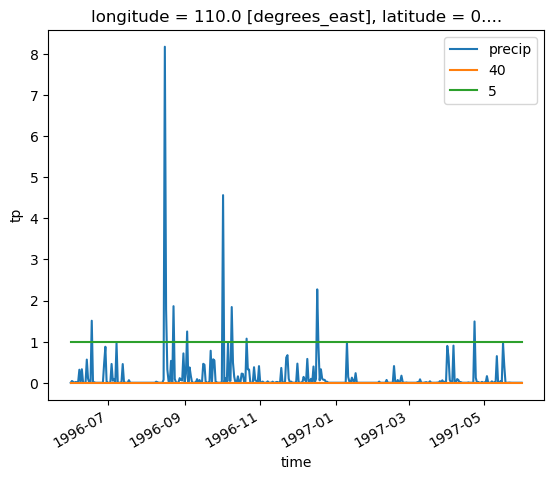

In [14]:
(1000 * precip_9697).plot()
plt.plot(precip_9697.time, larger_than_40mm)
plt.plot(precip_9697.time, less_than_5mm)
plt.legend(['precip', '40', '5'])

nan nan (400, 1440)


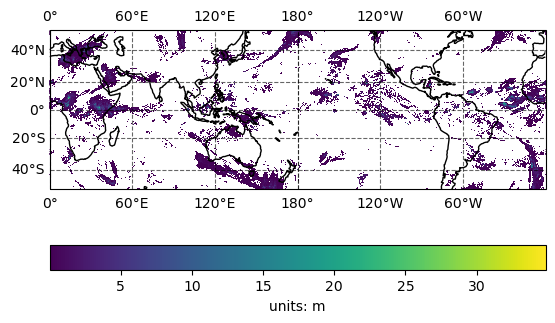

In [106]:
proj = ccrs.Mercator(central_longitude=180.0)
fig, ax = plt.subplots(subplot_kw={'projection': proj})
im = ax.pcolormesh(np.linspace(0, 360, data.shape[1]), np.linspace(50, -50, data.shape[0]), data, 
                   transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.6, linewidth=0.8, linestyle='dashed')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()

cbar = fig.colorbar(im, label='units: m', orientation='horizontal')